In [2]:
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

In [3]:
def euclidean_distance(point1, point2):
    """
    Computes euclidean distance of point1 and point2.
    
    point1 and point2 are lists.
    """
    return np.linalg.norm(np.array(point1) - np.array(point2))

def clusters_distance(cluster1, cluster2):
    """
    Computes distance between two clusters.
    
    cluster1 and cluster2 are lists of lists of points
    """
    return max([euclidean_distance(point1, point2) for point1 in cluster1 for point2 in cluster2])
  
def clusters_distance_2(cluster1, cluster2):
    """
    Computes distance between two centroids of the two clusters
    
    cluster1 and cluster2 are lists of lists of points
    """
    cluster1_center = np.average(cluster1, axis=0)
    cluster2_center = np.average(cluster2, axis=0)
    return euclidean_distance(cluster1_center, cluster2_center)


class AgglomerativeClustering:
    
    def __init__(self, k=2, initial_k=25):
        self.k = k
        self.initial_k = initial_k
        
    def initial_clusters(self, points):
        """
        partition pixels into self.initial_k groups based on color similarity
        """
        groups = {}
        d = int(256 / (self.initial_k))
        for i in range(self.initial_k):
            j = i * d
            groups[(j, j, j)] = []
        for i, p in enumerate(points):
            if i%100000 == 0:
                print('processing pixel:', i)
            go = min(groups.keys(), key=lambda c: euclidean_distance(p, c))  
            groups[go].append(p)
        return [g for g in groups.values() if len(g) > 0]
        
    def fit(self, points):

        # initially, assign each point to a distinct cluster
        print('Computing initial clusters ...')
        self.clusters_list = self.initial_clusters(points)
        print('number of initial clusters:', len(self.clusters_list))
        print('merging clusters ...')

        while len(self.clusters_list) > self.k:

            # Find the closest (most similar) pair of clusters
            cluster1, cluster2 = min([(c1, c2) for i, c1 in enumerate(self.clusters_list) for c2 in self.clusters_list[:i]],
                 key=lambda c: clusters_distance_2(c[0], c[1]))

            # Remove the two clusters from the clusters list
            self.clusters_list = [c for c in self.clusters_list if c != cluster1 and c != cluster2]

            # Merge the two clusters
            merged_cluster = cluster1 + cluster2

            # Add the merged cluster to the clusters list
            self.clusters_list.append(merged_cluster)

            print('number of clusters:', len(self.clusters_list))
        
        print('assigning cluster num to each point ...')
        self.cluster = {}
        for cl_num, cl in enumerate(self.clusters_list):
            for point in cl:
                self.cluster[tuple(point)] = cl_num
                
        print('Computing cluster centers ...')
        self.centers = {}
        for cl_num, cl in enumerate(self.clusters_list):
            self.centers[cl_num] = np.average(cl, axis=0)
                    


    def predict_cluster(self, point):
        """
        Find cluster number of point
        """
        # assuming point belongs to clusters that were computed by fit functions
        return self.cluster[tuple(point)]

    def predict_center(self, point):
        """
        Find center of the cluster that point belongs to
        """
        point_cluster_num = self.predict_cluster(point)
        center = self.centers[point_cluster_num]
        return center

In [11]:
image = imread("test images/284095.jpg")


In [16]:
pixels = image.reshape((-1,3))
n_clusters = 2
agglo = AgglomerativeClustering(k=n_clusters, initial_k=25)
agglo.fit(pixels)
new_img = [[agglo.predict_center(list(pixel)) for pixel in row] for row in image]
new_img = np.array(new_img, np.uint8)

Computing initial clusters ...
processing pixel: 0
processing pixel: 100000
number of initial clusters: 25
merging clusters ...
number of clusters: 24
number of clusters: 23
number of clusters: 22
number of clusters: 21
number of clusters: 20
number of clusters: 19
number of clusters: 18
number of clusters: 17
number of clusters: 16
number of clusters: 15
number of clusters: 14
number of clusters: 13
number of clusters: 12
number of clusters: 11
number of clusters: 10
number of clusters: 9
number of clusters: 8
number of clusters: 7
number of clusters: 6
number of clusters: 5
number of clusters: 4
number of clusters: 3
number of clusters: 2
assigning cluster num to each point ...
Computing cluster centers ...


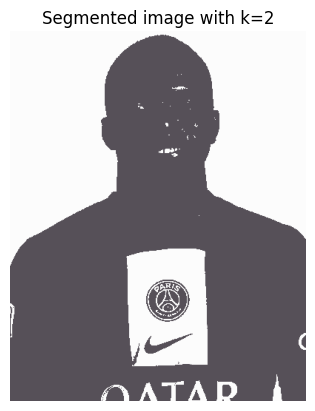

In [17]:
plt.imshow(new_img)
plt.axis('off')
plt.title(f'Segmented image with k={n_clusters}')

plt.savefig('agglomerativeResult.png', bbox_inches='tight', dpi = 1000)

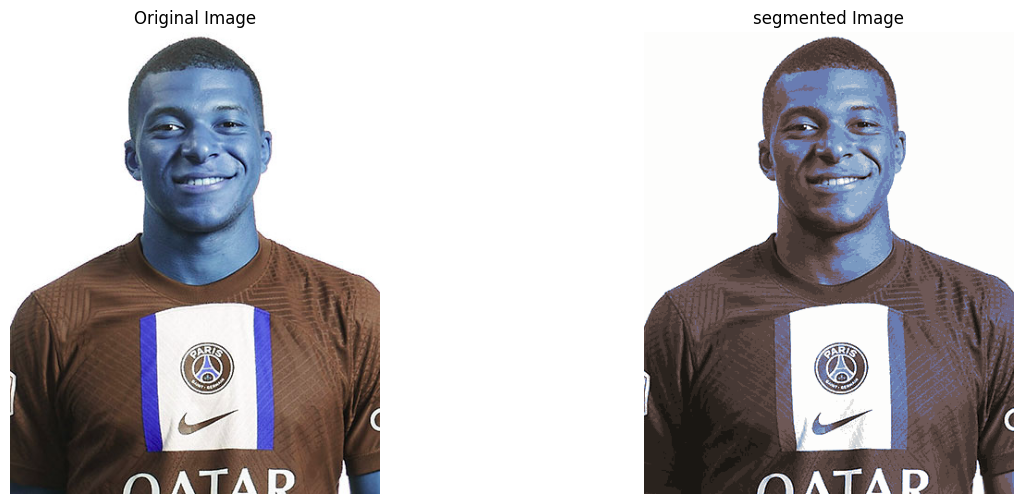

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
clusters_list = []
cluster = {}
centers = {}

def calculate_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def clusters_average_distance(cluster1, cluster2):
   
    cluster1_center = np.average(cluster1)
    cluster2_center = np.average(cluster2)
    return calculate_distance(cluster1_center, cluster2_center) 

def initial_clusters(image_clusters):
  
    global initial_k
    groups = {}
    cluster_color = int(256 / initial_k)
    for i in range(initial_k):
        color = i * cluster_color
        groups[(color, color, color)] = []
    for i, p in enumerate(image_clusters):
        go = min(groups.keys(), key=lambda c: np.sqrt(np.sum((p - c) ** 2)))
        groups[go].append(p)
    return [group for group in groups.values() if len(group) > 0]

def get_cluster_center( point):
    global cluster
    point_cluster_num = cluster[tuple(point)]
    center = centers[point_cluster_num]
    return center

def get_clusters(image_clusters):
    global clusters_list
    clusters_list = initial_clusters(image_clusters)

    while len(clusters_list) > clusters_number:
        cluster1, cluster2 = min(
            [(c1, c2) for i, c1 in enumerate(clusters_list) for c2 in clusters_list[:i]],
            key=lambda c: clusters_average_distance(c[0], c[1]))

        clusters_list = [cluster_itr for cluster_itr in clusters_list if cluster_itr != cluster1 and cluster_itr != cluster2]

        merged_cluster = cluster1 + cluster2

        clusters_list.append(merged_cluster)

    global cluster 
    for cl_num, cl in enumerate(clusters_list):
        for point in cl:
            cluster[tuple(point)] = cl_num

    global centers 
    for cl_num, cl in enumerate(clusters_list):
        centers[cl_num] = np.average(cl, axis=0)

def apply_agglomerative_clustering(image, number_of_clusters,initial_number_of_clusters):
    global clusters_number
    global initial_k

    clusters_number = number_of_clusters
    initial_k = initial_number_of_clusters 
    flattened_image = np.copy(image.reshape((-1, 3)))

    get_clusters(flattened_image)
    output_image = []
    for row in image:
        rows = []
        for col in row:
            rows.append(get_cluster_center(list(col)))
        output_image.append(rows)    
    output_image = np.array(output_image, np.uint8)
    return output_image    


img = cv2.imread("test images/284095.jpg")
segmented_image = apply_agglomerative_clustering(img,15,30)
# cv2.imshow('Original Image', img)
# cv2.imshow('Segmented Image', segmented_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].set_axis_off()
ax[1].imshow(segmented_image ,cmap = "gray")
ax[1].set_title('segmented Image')
ax[1].set_axis_off()
plt.show()
